In [1]:
import os, shutil, pathlib
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-08-22 13:50:23.199171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 13:50:23.249671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 13:50:23.952096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Create a smaller subset of dogs-vs-cats-db INTO training, validation, and test directories

In [2]:
original_dir = pathlib.Path('./dogs-vs-cats-db/train') # path to the directory where original dataset was uncompressed
new_base_dir = pathlib.Path('./cats_vs_dogs_small') # directory for our smaller dataset

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst = dir / fname)

if not os.path.exists('./cats_vs_dogs_small'):
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)

DATA AUGMENTATION NEEDED

In [3]:
# import tensorflow as tf
# tf.config.list_physical_devices("GPU")

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2023-08-22 13:50:24.798721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 13:50:24.822527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 13:50:24.822734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Setting up the architecture of the model

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False
)
# conv_base.trainable = Falserainable = False
# -- FINE TUNING --
conv_base.trainable = True
for layer in conv_base.layers[:-4]: # now freeze all layers except the last 4 (block of 3 conv-nets and 1 max-pool)
    layer.trainable = False

In [6]:
# model expects rgb images of size 180 x 180
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# x = layers.Rescaling(1./255) (x)#(inputs)

# x = layers.Conv2D(filters=32, kernel_size=3, activation="relu") (x)
# x = layers.MaxPooling2D(pool_size=2) (x)

# x = layers.Conv2D(filters=64, kernel_size=3, activation="relu") (x)
# x = layers.MaxPooling2D(pool_size=2) (x)

# x = layers.Conv2D(filters=128, kernel_size=3, activation="relu") (x)
# x = layers.MaxPooling2D(pool_size=2) (x)

# x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
# x = layers.MaxPooling2D(pool_size=2) (x)

# x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
# x = layers.Flatten() (x)

# -- feature extraction with VGG16 pre-trained convolutional base --
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten() (x)
x = layers.Dense(256) (x)
# -- --

x = layers.Dropout(0.5) (x)

outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
# model.summary()

Use `image_dataset_from_directory(dir)` from Keras to read img into model

* list the subdirectories of `dir` and assumes each one contains images from one of the classes
* then index the image files in each subdirectory
* this creates and returns a `tf.data.Dataset` object, which is configured to...
> 1. read these files,
> 2. shuffle them,
> 3. decode them to tensors,
> 4. resize to shared size,
> 5. pack them into batches.

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
# displaying the shapes of the data and labels yielded by the 'Dataset' obj

for data_batch, labels_batch, in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [10]:
# model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
# -- FINE TUNING --
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # filepath="convnet_from_scratch_with_augmentation.x",
        filepath="fine_tuning.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [11]:
# MODEL FIT into 'history'
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50


2023-08-22 13:50:27.374585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-22 13:50:28.341104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22 13:50:28.365999: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb1893227b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-22 13:50:28.366026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-08-22 13:50:28.369906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-22 13:50:28.465446: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

63/63 [==============================] - ETA: 0s - loss: 3.2946 - accuracy: 0.7675INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 15s 192ms/step - loss: 3.2946 - accuracy: 0.7675 - val_loss: 0.6478 - val_accuracy: 0.9330
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.8820INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 187ms/step - loss: 1.0709 - accuracy: 0.8820 - val_loss: 0.3603 - val_accuracy: 0.9540
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.9150INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 191ms/step - loss: 0.6073 - accuracy: 0.9150 - val_loss: 0.2777 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.9320INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 189ms/step - loss: 0.4909 - accuracy: 0.9320 - val_loss: 0.2652 - val_accuracy: 0.9680
Epoch 5/50
63/63 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.9220INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 11s 176ms/step - loss: 0.4438 - accuracy: 0.9220 - val_loss: 0.2145 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9520INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 194ms/step - loss: 0.2208 - accuracy: 0.9520 - val_loss: 0.2055 - val_accuracy: 0.9680
Epoch 7/50
63/63 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9570INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 11s 180ms/step - loss: 0.1678 - accuracy: 0.9570 - val_loss: 0.1660 - val_accuracy: 0.9750
Epoch 8/50
63/63 [==============================] - 10s 160ms/step - loss: 0.2024 - accuracy: 0.9580 - val_loss: 0.1668 - val_accuracy: 0.9700
Epoch 9/50
63/63 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9635INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 11s 180ms/step - loss: 0.1507 - accuracy: 0.9635 - val_loss: 0.1608 - val_accuracy: 0.9740
Epoch 10/50
63/63 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9630INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 11s 182ms/step - loss: 0.1280 - accuracy: 0.9630 - val_loss: 0.1508 - val_accuracy: 0.9760
Epoch 11/50
63/63 [==============================] - 10s 162ms/step - loss: 0.1427 - accuracy: 0.9675 - val_loss: 0.1569 - val_accuracy: 0.9740
Epoch 12/50
63/63 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9685INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 195ms/step - loss: 0.1229 - accuracy: 0.9685 - val_loss: 0.1505 - val_accuracy: 0.9730
Epoch 13/50
63/63 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9665INFO:tensorflow:Assets written to: fine_tuning.x/assets


INFO:tensorflow:Assets written to: fine_tuning.x/assets


63/63 [==============================] - 12s 185ms/step - loss: 0.1117 - accuracy: 0.9665 - val_loss: 0.1189 - val_accuracy: 0.9770
Epoch 14/50
63/63 [==============================] - 10s 164ms/step - loss: 0.0860 - accuracy: 0.9760 - val_loss: 0.1371 - val_accuracy: 0.9750
Epoch 15/50
63/63 [==============================] - 10s 165ms/step - loss: 0.0788 - accuracy: 0.9765 - val_loss: 0.1617 - val_accuracy: 0.9740
Epoch 16/50
63/63 [==============================] - 10s 165ms/step - loss: 0.0641 - accuracy: 0.9790 - val_loss: 0.1768 - val_accuracy: 0.9780
Epoch 17/50
63/63 [==============================] - 10s 165ms/step - loss: 0.0661 - accuracy: 0.9775 - val_loss: 0.1765 - val_accuracy: 0.9780
Epoch 18/50
63/63 [==============================] - 10s 165ms/step - loss: 0.0665 - accuracy: 0.9850 - val_loss: 0.1821 - val_accuracy: 0.9790
Epoch 19/50
63/63 [==============================] - 10s 165ms/step - loss: 0.0720 - accuracy: 0.9815 - val_loss: 0.1498 - val_accuracy: 0.9790
Epoc

Plot training accuracy vs validation accuracy

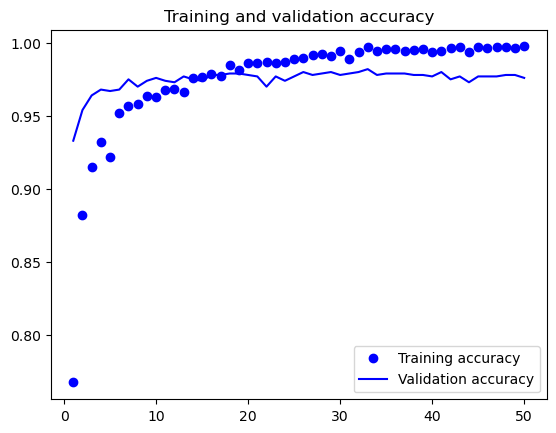

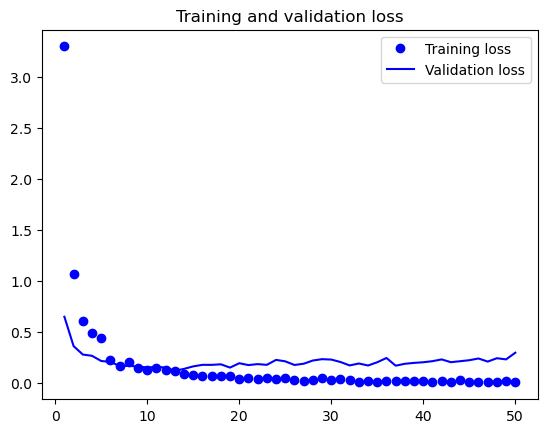

In [12]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]# test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.x")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Evaluate model on test set

In [13]:
# test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.x")
test_model = keras.models.load_model("fine_tuning.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 108ms/step - loss: 0.1405 - accuracy: 0.9745
Test accuracy: 0.975


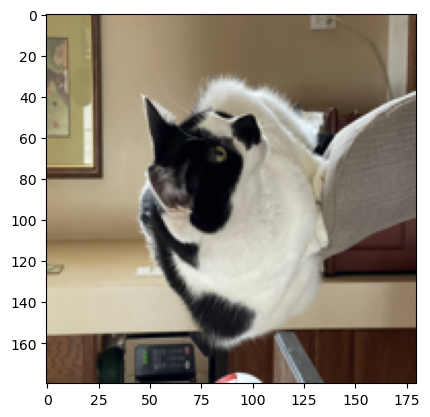

In [44]:
from PIL import Image

test_dog_path = './cats_vs_dogs_small/test/dog/dog.1507.jpg'
test_cat_path = './cats_vs_dogs_small/test/cat/cat.1500.jpg'
ivy = 'ivyBetter.png'
ivy2 = 'ivyVague.jpg'
herbie1 = 'herbieFace.jpg'
herbie2 = 'herbieSitting.jpg'
herbie3 = 'herbieSleeping.jpg'

image = Image.open(herbie2)

image = image.convert('RGB')
image = image.resize([180, 180])
plt.figure()
plt.imshow(image)

In [45]:
np_expanded_img = np.expand_dims(image, axis=0)
# img_scaled = np_expanded_img / 255.0

In [46]:
result = test_model.predict(np_expanded_img)
result

1/1 [==============================] - 0s 13ms/step


array([[5.360691e-14]], dtype=float32)

In [47]:
if result >= 0.5:
    print("THIS IS A VERY CUTE DOG :)")
else:
    print("THIS IS A VERY CUTE CAT :)")

THIS IS A VERY CUTE CAT :)


: 